In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

# Load the training and validation sets
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\Dhruv\OneDrive - iTachi World\Desktop\animal-image-classifications-master\animal-image-classifications-master\data\train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    r"C:\Users\Dhruv\OneDrive - iTachi World\Desktop\animal-image-classifications-master\animal-image-classifications-master\data\validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation consistency
)

Found 13412 images belonging to 6 classes.
Found 2549 images belonging to 6 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the base model with pre-trained weights
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model layers initially

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [3]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [6]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8185 - loss: 0.5511

C:\Users\Dhruv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


420/420 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8186 - loss: 0.5507 - val_accuracy: 0.9506 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 2/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 273s 649ms/step - accuracy: 0.9132 - loss: 0.2661 - val_accuracy: 0.9529 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 3/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 291s 691ms/step - accuracy: 0.9208 - loss: 0.2474 - val_accuracy: 0.9537 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 4/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 287s 683ms/step - accuracy: 0.9214 - loss: 0.2336 - val_accuracy: 0.9537 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 5/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 285s 679ms/step - accuracy: 0.9286 - loss: 0.2169 - val_accuracy: 0.9580 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 6/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 291s 693ms/step - accuracy: 0.9325 - loss: 0.2011 - val_accuracy: 0.9584 - val_loss: 0.1148 - learning_rate: 0.0010
Epoch 7/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 285s 680ms/step - accuracy: 0.9325 - l

In [7]:
# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-20:]:  # Adjust the number of layers as needed
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 299s 699ms/step - accuracy: 0.9062 - loss: 0.2832 - val_accuracy: 0.9635 - val_loss: 0.1043 - learning_rate: 1.0000e-05
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 320s 761ms/step - accuracy: 0.9249 - loss: 0.2286 - val_accuracy: 0.9635 - val_loss: 0.1032 - learning_rate: 1.0000e-05
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 298s 711ms/step - accuracy: 0.9294 - loss: 0.2208 - val_accuracy: 0.9635 - val_loss: 0.0991 - learning_rate: 1.0000e-05
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 313s 745ms/step - accuracy: 0.9375 - loss: 0.1911 - val_accuracy: 0.9643 - val_loss: 0.0974 - learning_rate: 1.0000e-05
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 291s 692ms/step - accuracy: 0.9407 - loss: 0.1844 - val_accuracy: 0.9647 - val_loss: 0.0968 - learning_rate: 1.0000e-05
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 290s 690ms/step - accuracy: 0.9371 - loss: 0.2051 - val_accuracy: 0.9651 - val_loss: 0.0947 - learning_rate: 1.0000e-05
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 

80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step
Weighted F1 Score: 0.966658596355484
Classification Report:
               precision    recall  f1-score   support

   Butterfly       0.92      0.93      0.92       248
     Chicken       0.98      0.96      0.97       467
    Elephant       0.98      0.99      0.98       202
       Horse       0.96      0.99      0.98       370
      Spider       0.97      0.97      0.97       944
    Squirrel       0.98      0.96      0.97       318

    accuracy                           0.97      2549
   macro avg       0.96      0.97      0.96      2549
weighted avg       0.97      0.97      0.97      2549



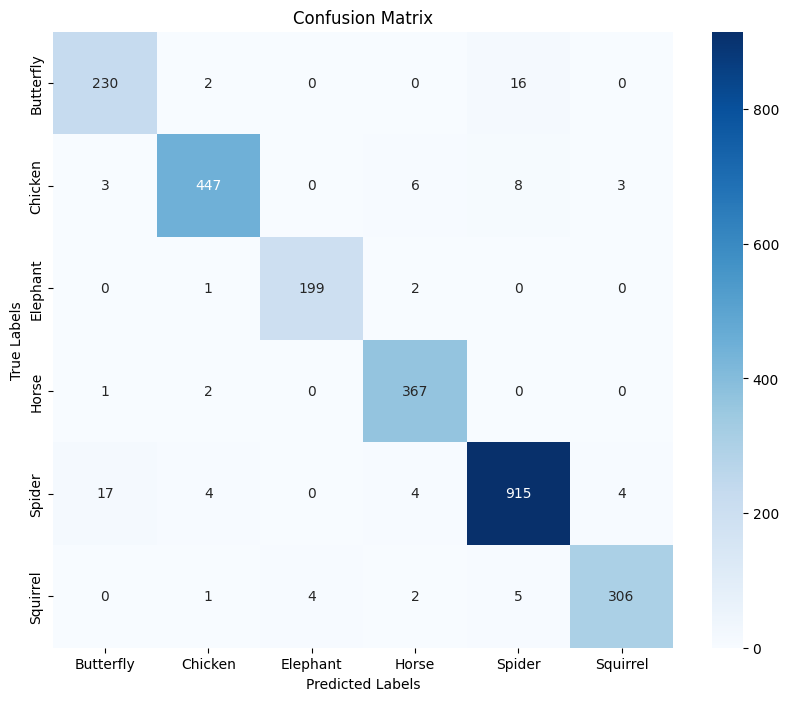

In [8]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate weighted F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)

# Print detailed classification report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [9]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the sightings data
data = pd.read_csv(r"C:\Users\Dhruv\OneDrive - iTachi World\Desktop\animal-image-classifications-master\Updated_National_Mammal_Atlas_Project.csv")
data.head()


,Scientific name,Common name,Species ID (TVK),Taxon Rank,Start date,Start date day,Start date month,Start date year,Latitude (WGS84),Longitude (WGS84),...,Kingdom,Phylum,Class,Order,Family,Genus,Country,State/Province,Vitality,Simplified Common name
0,Capreolus capreolus,Roe Deer,NHMSYS0000080203,species,31/01/2018,31,1,2018,57.400200,-4.267900,...,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Capreolus,United Kingdom,Scotland,NaN,Deer
1,Erinaceus europaeus,West European Hedgehog,NBNSYS0000005078,species,20/01/2021,20,1,2021,51.519214,-0.738969,...,Animalia,Chordata,Mammalia,Insectivora,Erinaceidae,Erinaceus,United Kingdom,England,NaN,Hedgehog
2,Halichoerus grypus,Grey Seal,NBNSYS0000005137,species,06/01/2016,6,1,2016,52.800000,1.600000,...,Animalia,Chordata,Mammalia,Carnivora,Phocidae,Halichoerus,United Kingdom,England,NaN,Seal
3,Talpa europaea,European Mole,NBNSYS0000005079,species,25/01/2017,25,1,2017,53.322473,-1.731987,...,Animalia,Chordata,Mammalia,Insectivora,Talpidae,Talpa,United Kingdom,England,NaN,Mole
4,Sciurus carolinensis,Squirels,NHMSYS0000332764,species,06/01/2016,6,1,2016,52.581700,-1.717600,...,Animalia,Chordata,Mammalia,Rodentia,Sciuridae,Sciurus,United Kingdom,England,NaN,Squirrel


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
Predicted Animal: Squirrel


C:\Users\Dhruv\AppData\Local\Temp\ipykernel_12396\6305984.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Start date'] = pd.to_datetime(data['Start date'], errors='coerce')
C:\Users\Dhruv\AppData\Local\Temp\ipykernel_12396\6305984.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animal_data['Time Period'] = animal_data['Start date'].dt.to_period("M")


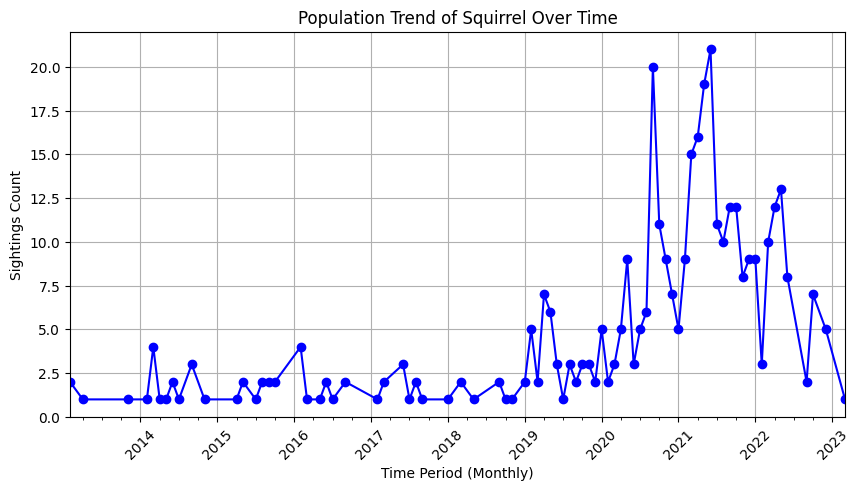

In [10]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_size = (224, 224)

def plot_animal_trend(data, selected_animal):
    # Convert "Start date" to datetime format
    data['Start date'] = pd.to_datetime(data['Start date'], errors='coerce')

    # Filter data for the selected animal
    animal_data = data[data['Common name'].str.lower() == selected_animal.lower()]

    if animal_data.empty:
        print(f"No data found for {selected_animal}")
    else:
        # Extract time period (e.g., monthly)
        animal_data['Time Period'] = animal_data['Start date'].dt.to_period("M")
        animal_data = animal_data.dropna(subset=['Start date', 'Time Period'])

        # Count sightings per time period
        trend_data = animal_data.groupby('Time Period').size()

        if not trend_data.empty:
            plt.figure(figsize=(10, 5))
            trend_data.plot(marker='o', color='b')
            plt.title(f"Population Trend of {selected_animal.capitalize()} Over Time")
            plt.xlabel("Time Period (Monthly)")
            plt.ylabel("Sightings Count")
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()
        else:
            print(f"No valid sightings data for {selected_animal} over the time periods.")

def predict_animal_with_graph(img_path, model, train_generator, data):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    # Map prediction to class label
    class_labels = train_generator.class_indices
    class_labels = {v: k for k, v in class_labels.items()}
    predicted_label = class_labels[predicted_class[0]]

    print(f"Predicted Animal: {predicted_label}")

    # Plot the trend graph for the predicted animal
    plot_animal_trend(data, predicted_label)

# Example usage
data = pd.read_csv(r"C:\Users\Dhruv\OneDrive - iTachi World\Desktop\animal-image-classifications-master\Updated_National_Mammal_Atlas_Project.csv")  # Load the dataset
predict_animal_with_graph(
    r"C:\Users\Dhruv\OneDrive - iTachi World\Desktop\animal-image-classifications-master\animal-image-classifications-master\data\test\Squirels\OIP-wCITkw6fPpEzkMFY3L-nNQHaGc.jpeg",
    model,
    train_generator,
    data
)

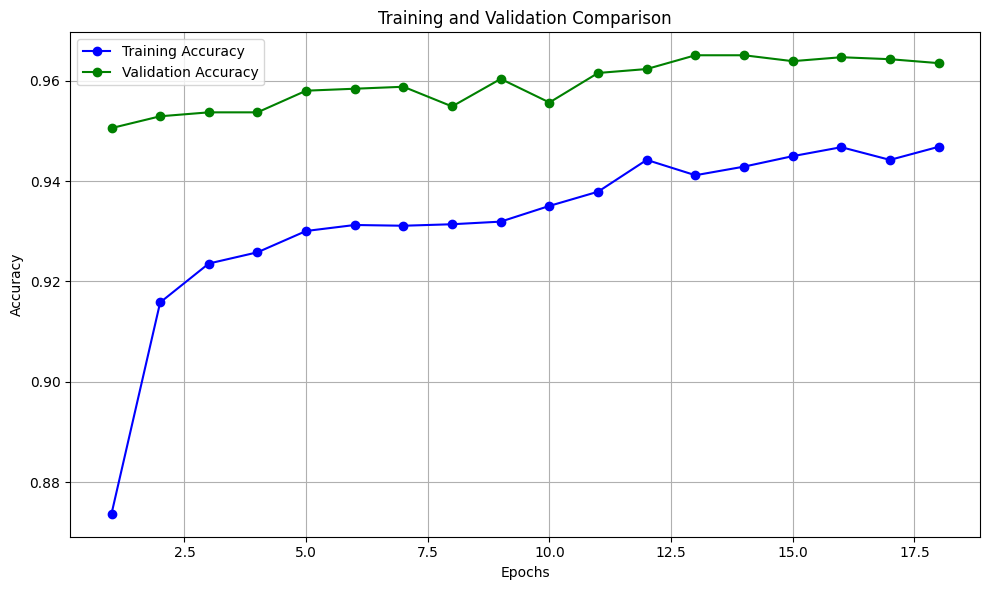

In [11]:
import matplotlib.pyplot as plt

def plot_accuracy_comparison(history, test_accuracy=None):
    # Extract training and validation accuracies
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g-o', label='Validation Accuracy')

    # Set plot details
    plt.title('Training and Validation Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy_comparison(history) 
